In [1]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import warnings
from functools import partial

In [2]:
from text_authorship.ta_model import load_df, train_crossval_twofold, get_encoders, train_test_split

[nltk_data] Downloading package stopwords to /home/dm12h/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
DFRAME_PATH=input()

In [5]:
df = load_df(DFRAME_PATH)

In [6]:
df

,author,book,text,text_no_punkt,lemmas,tags,tokens,counts,probs,word_avg_length,words_per_sentence,exclamation_density,question_density,comma_density,dialogue_density
0,Аверченко,Averchenko_A-T-Averchenko-Sobranie-sochineniy-...,аркадий тимофеевич аверченко\nсобрание сочинен...,deleted deleted deleted собрание сочинений в ш...,deleted deleted deleted собрание сочинение шес...,deleted deleted deleted 8_NOUN 9_NOUN 5_NUMR 1...,deleted deleted deleted собрание сочинений в ш...,242,0.000043,4.617747,3.141199,0.052632,0.000000,0.000000,0.000000
1,Аверченко,Averchenko_A-T-Averchenko-Sobranie-sochineniy-...,"стремясь вырваться из этой беспросветности, он...",стремясь вырваться из этой беспросветности он ...,стремиться вырваться беспросветность обращатьс...,8_GRND 9_INFN 15_NOUN 10_VERB 13_ADJF 5_NOUN d...,"стремясь вырваться из этой беспросветности , о...",242,0.000043,4.468048,2.805954,0.028571,0.000000,0.000000,0.142857
2,Аверченко,Averchenko_A-T-Averchenko-Sobranie-sochineniy-...,— разрешите сесть или продолжать мне стоя? — ш...,разрешите сесть или продолжать мне стоя шутлив...,разрешить сесть продолжать стоя шутливо спроси...,9_VERB 5_INFN 10_INFN 4_ADVB 7_ADVB 7_VERB del...,— разрешите сесть или продолжать мне стоя ? — ...,242,0.000043,4.405085,2.508922,0.020833,0.020833,0.020833,0.166667
3,Аверченко,Averchenko_A-T-Averchenko-Sobranie-sochineniy-...,а в последнем номере не пропущена даже карикат...,а в последнем номере не пропущена даже карикат...,последний номер пропустить карикатура осмеиват...,9_ADJF 6_NOUN 9_PRTS 10_NOUN 11_PRTF 5_ADJF 5_...,а в последнем номере не пропущена даже карикат...,242,0.000043,4.867958,3.206627,0.000000,0.000000,0.000000,0.043478
4,Аверченко,Averchenko_A-T-Averchenko-Sobranie-sochineniy-...,помимо постоянных авторов «сатирикона» и «ново...,помимо постоянных авторов сатирикона и нового ...,помимо постоянный автор сатирикона новый сатир...,6_PREP 10_ADJF 7_NOUN 10_NOUN 6_ADJF 10_NOUN d...,помимо постоянных авторов « сатирикона » и « н...,242,0.000043,4.693370,2.947205,0.026316,0.052632,0.052632,0.105263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18486,Чехов,zhivoi-tovar.epub,"— это ужасно, григорий васильич! — заговорил б...",это ужасно deleted deleted заговорил deleted у...,это ужасно deleted deleted заговорить deleted ...,3_PRCL 6_ADVB deleted deleted 9_VERB deleted 6...,"— это ужасно , deleted deleted ! — заговорил d...",20,0.000223,4.146580,2.449703,0.358491,0.188679,0.188679,0.301887
18487,Чехов,zhivoi-tovar.epub,грохольский жил всё в той же даче… надежды и ж...,грохольский жил всё в той же даче надежды и же...,грохольский жить всё дача надежда желание мале...,11_ADJF 3_VERB 3_PRCL 4_NOUN 7_NOUN 7_NOUN 9_A...,грохольский жил всё в той же даче… надежды и ж...,20,0.000223,4.396352,2.846569,0.142857,0.028571,0.028571,0.000000
18488,Чехов,zhivoi-tovar.epub,бугров держал лизу за талию и говорил ей:\n— м...,deleted держал deleted за талию и говорил ей м...,deleted держать deleted талия говорить милый д...,deleted 6_VERB deleted 5_NOUN 7_VERB 5_ADJF 6_...,deleted держал deleted за талию и говорил ей :...,20,0.000223,4.001538,2.382628,0.483333,0.200000,0.200000,0.233333
18489,Чехов,zhivoi-tovar.epub,"— тебе скучно, лизочка? — заговорил он после н...",тебе скучно лизочка заговорил он после непродо...,скучно лизочко заговорить непродолжительный мо...,6_ADVB 7_NOUN 9_VERB 18_ADJF 8_NOUN 8_VERB 6_A...,"— тебе скучно , лизочка ? — заговорил он после...",20,0.000223,4.079268,2.359026,0.161290,0.145161,0.145161,0.306452


In [7]:
def get_top_features(label_enc, data_enc, clf, n):
    names = label_enc.classes_
    coeffs = clf.coef_
    author_dict = dict()
    for i, author in enumerate(names):
        args_sorted = list(reversed(np.argsort(coeffs[i])[-n:]))
        features = [data_enc.find_idx(idx) for idx in args_sorted]
        author_dict[author] = features
    df = pd.DataFrame(author_dict)
    return df

### Попробуем простую регрессию по 1 колонке:
С помощью optuna подберем параметр регуляризации, длину векторизированного представления текста, и лучшую колонку

In [8]:
def objective(trial: optuna.Trial):
    regularization = trial.suggest_float("lambda", low=0.001, high=1000)
    vector_size = trial.suggest_int("multiplier", low=1,  high=10)
    target_column = trial.suggest_categorical("col", ["tokens", "lemmas", "tags"])
    n_grams = trial.suggest_int("n_top", low=1, high=4)
    param_dict = {
        target_column: {
            "max_count": 5000*vector_size,
            "n_min":1,
            "n":n_grams
        }
    }
    clf = LogisticRegression(class_weight="balanced",
                             C=regularization,
                             warm_start=False,
                             max_iter=500)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        scores = train_crossval_twofold(df, clf, target_column, vectorizer_dict=param_dict, avg="macro")
        return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2023-03-01 08:53:43,999] A new study created in memory with name: no-name-4c0f6410-f8bd-4d5a-a372-8d9ff0fa6913
[I 2023-03-01 08:59:04,196] Trial 0 finished with value: 0.745787192514221 and parameters: {'lambda': 181.472021666141, 'multiplier': 3, 'col': 'tokens', 'n_top': 4}. Best is trial 0 with value: 0.745787192514221.
[I 2023-03-01 09:03:01,933] Trial 1 finished with value: 0.45770500740581943 and parameters: {'lambda': 312.56257840368045, 'multiplier': 3, 'col': 'tags', 'n_top': 3}. Best is trial 0 with value: 0.745787192514221.
[I 2023-03-01 09:06:46,680] Trial 2 finished with value: 0.7299144599542262 and parameters: {'lambda': 245.25764240084405, 'multiplier': 1, 'col': 'lemmas', 'n_top': 4}. Best is trial 0 with value: 0.745787192514221.
[I 2023-03-01 09:10:25,511] Trial 3 finished with value: 0.7168364878821846 and parameters: {'lambda': 84.48894684069208, 'multiplier': 9, 'col': 'lemmas', 'n_top': 3}. Best is trial 0 with value: 0.745787192514221.
[I 2023-03-01 09:15:32,

In [12]:
best_params = study.best_params
best_params

{'lambda': 181.472021666141, 'multiplier': 3, 'col': 'tokens', 'n_top': 4}

In [17]:
optuna.importance.get_param_importances(study)

OrderedDict([('col', 0.748094065529188),
             ('lambda', 0.22047536779173826),
             ('n_top', 0.0312922270635871),
             ('multiplier', 0.0001383396154866577)])

### Добавим 2ю колонку:
Несмотря на дублирование данных, добавление дополнительной информации позволяет увеличить score. Из многочисленных запусков видно, что оптимальное С для регуляризации находится где-то около 600, а к размеру ngramm и длине вектора результаты не очень чувствительны

In [16]:
def optimize_doubles(trial, prev_params):
    main_col = prev_params["col"]
    candidates = {"tokens", "lemmas", "tags"}
    candidates.discard(main_col)

    second_col = trial.suggest_categorical("second_col", list(candidates))
    vector_size = trial.suggest_int("multiplier", low=1,  high=10)
    regularization = trial.suggest_float("lambda", low=0.001, high=1000)
    n_grams = trial.suggest_int("n_top", low=1, high=4)

    clf = LogisticRegression(
                            C=regularization,
                            class_weight="balanced",
                            warm_start=False,
                            max_iter=500)
    param_dict = {
        main_col: {
            "max_count": 5000*prev_params["multiplier"],
            "n_min":1,
            "n":prev_params["n_top"]
        },
        second_col: {
            "max_count": 5000*vector_size,
            "n_min":1,
            "n": n_grams
        }
    }
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        scores = train_crossval_twofold(df, clf, main_col,second_col, vectorizer_dict=param_dict, avg="macro")
        return np.mean(scores)

follow_up_study = optuna.create_study(direction="maximize")
follow_up_study.optimize(partial(optimize_doubles, prev_params=best_params), n_trials=10)

[I 2023-03-01 09:42:37,997] A new study created in memory with name: no-name-f2ce7a66-729d-4d5a-9cb7-430e961fbff7
[I 2023-03-01 09:50:01,819] Trial 0 finished with value: 0.77608039660908 and parameters: {'second_col': 'lemmas', 'multiplier': 2, 'lambda': 676.984734794044, 'n_top': 3}. Best is trial 0 with value: 0.77608039660908.
[I 2023-03-01 09:58:52,038] Trial 1 finished with value: 0.7483338242131993 and parameters: {'second_col': 'tags', 'multiplier': 4, 'lambda': 690.2034773130847, 'n_top': 4}. Best is trial 0 with value: 0.77608039660908.
[I 2023-03-01 10:06:12,642] Trial 2 finished with value: 0.7635275955113148 and parameters: {'second_col': 'lemmas', 'multiplier': 4, 'lambda': 68.4748810680112, 'n_top': 4}. Best is trial 0 with value: 0.77608039660908.
[I 2023-03-01 10:13:47,746] Trial 3 finished with value: 0.7853255534280614 and parameters: {'second_col': 'lemmas', 'multiplier': 10, 'lambda': 603.6571448583995, 'n_top': 1}. Best is trial 3 with value: 0.7853255534280614.
[

In [18]:
optuna.importance.get_param_importances(follow_up_study)

OrderedDict([('second_col', 0.5629371015989246),
             ('lambda', 0.34812037515215233),
             ('n_top', 0.06016824071808018),
             ('multiplier', 0.028774282530842927)])

### Добавим численные признаки

Будем использовать полученные ранее параметры для подбора лучшей модели

In [7]:
scalar_features = ["word_avg_length", "words_per_sentence",
                   "exclamation_density", "question_density",
                   "comma_density", "dialogue_density"]

def final_obj(trial):
    clf = LogisticRegression(
                            C=600,
                            class_weight="balanced",
                            warm_start=False,
                            max_iter=500)

    main_col_count = trial.suggest_int("count_main", low=5000,  high=25000)
    second_col_count = trial.suggest_int("count_second", low=5000,  high=25000)
    main_col_n = trial.suggest_int("n_top_main", low=1, high=4)
    second_col_n = trial.suggest_int("n_top_second", low=1, high=4)

    param_dict = {
        "tokens": {
            "max_count": main_col_count,
            "n_min":1,
            "n":main_col_n,
        },
        "lemmas": {
            "max_count": second_col_count,
            "n_min":1,
            "n": second_col_n
        }
    }
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        scores = train_crossval_twofold(df, clf, "tokens", "lemmas", scalar_features, vectorizer_dict=param_dict, avg="macro")
        return np.mean(scores)

follow_up_study = optuna.create_study(direction="maximize")
follow_up_study.optimize(final_obj, n_trials=10)

[I 2023-03-01 14:10:21,096] A new study created in memory with name: no-name-e72a1be4-f285-43ca-9e96-607de7d2d684
[I 2023-03-01 14:16:51,496] Trial 0 finished with value: 0.7305064630138566 and parameters: {'count_main': 12339, 'count_second': 12816, 'n_top_main': 2, 'n_top_second': 3}. Best is trial 0 with value: 0.7305064630138566.
[I 2023-03-01 14:23:53,082] Trial 1 finished with value: 0.7335515246099853 and parameters: {'count_main': 6423, 'count_second': 18287, 'n_top_main': 3, 'n_top_second': 2}. Best is trial 1 with value: 0.7335515246099853.
[I 2023-03-01 14:30:28,004] Trial 2 finished with value: 0.7416893275377844 and parameters: {'count_main': 9039, 'count_second': 22300, 'n_top_main': 3, 'n_top_second': 1}. Best is trial 2 with value: 0.7416893275377844.
[I 2023-03-01 14:37:46,931] Trial 3 finished with value: 0.7354374052720114 and parameters: {'count_main': 13826, 'count_second': 24009, 'n_top_main': 3, 'n_top_second': 2}. Best is trial 2 with value: 0.7416893275377844.


К сожалению, добавление чиленных признаков не позволило добиться нового максимума в результатах. Остановимся на численно лучших параметрах и проанализируем полученную с ними модель

### Лучший вариант

Чтобы визуализировать модель, мы не пользуемся кросс-валидацией, а берем обычное разбиение.
Добавим к частям речи и тегам рассчитанные ранее скалярные параметры. они несущественно увеличивают число признаков, но могут быть полезными, так как вектор слов может не покрывать отдельные отрезки


In [8]:
param_dict = {
    "tokens": {
        "max_count": 15000,
        "n_min":1,
        "n":4,
    },
    "lemmas": {
        "max_count": 50000,
        "n_min":1,
        "n": 1
    }
}

df_train, df_test, y_train, y_test = train_test_split(df, share=0.7)
data_enc, label_enc = get_encoders(df, df_train, param_dict.keys(), param_dict)

x_train = data_enc.fit_transform(df_train)
x_test = data_enc.transform(df_test)
y_train = label_enc.transform(y_train)
y_test = label_enc.transform(y_test)

clf = LogisticRegression(penalty="l2",
                         random_state=10,
                         C=603,
                         class_weight="balanced",
                         max_iter=1000)
clf.fit(x_train, y_train)

LogisticRegression(C=603, class_weight='balanced', max_iter=1000,
                   random_state=10)

In [9]:
f1_score(clf.predict(x_test), y_test, average="macro")

0.8519774675454916

Посмотрим на наиболее весомые фичи для каждого класса

In [10]:
get_top_features(label_enc, data_enc, clf, n=15)

,Аверченко,Булгаков,Бунин,Гоголь,Горький,Достоевский,Карамзин,Куприн,Лермонтов,Мордовцев,Пушкин,Салтыков-Щедрин,Толстой,Тургенев,Чехов
0,сейчас,мастер,возле,deleted deleted,человек,всё,1792,точно,1837,1880,дубровский,салтыков,который,рудин,грохольский
1,вы,пьеса,возле,уже,самгинуть,вдруг,сердце,точно,казбич,да,яицкий,салтык,кить,лаврецкий,граф
2,сатирикона,ответить,жизнь,1841,тоже,смотреть,актеон,царь,отвечать,талицкий,михельсон,однако,сказал,промолвить,всё
3,король,советский,писать,чтобы,рабочий,всё,свой,нежный,куршуд,государь,1827,владимирыч,сказать,лаврецкий,глядеть
4,чего,ответил,например,сказал deleted,самгину,даже,древнегреческий,все,уж,deleted,отвечать,словно,ежели,гедеоновский,грохольский
5,deleted,прокуратор,опять,какой,ещё,теперь,мочь,вдруг,княжна,девушка,крепость,даже,кити,рудин,поглядеть
6,крысак,тут,все,костанжочь,всё,верховенский,герой,ранний,кавказец,девочка,казак,иудушка,воскресение,пандалевский,следователь
7,если,квартира,ответить,парубок,её,то,ах,сейчас,капитан,словно,маиор,крутогорский,чтобы,ней,сад
8,ты,года,подгаевский,весь,варавка,роман,для,гамбринус,повесть,словно,его,однако,было,пигас,монах
9,новый,гудок,например,бы,жить,подросток,хотеть,голос,минута,государь,её,чтоб,граф,да,раббек


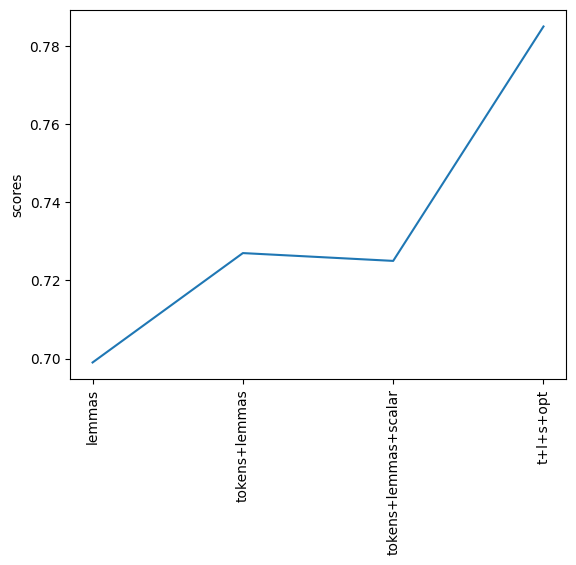

In [32]:
scores_graph = [0.699, 0.727, 0.725, 0.785]
x_ = list(range(4))
import matplotlib.pyplot as plt
plt.plot(x_, scores_graph)
plt.ylabel("scores")
xtick_labels = ["lemmas", "tokens+lemmas", "tokens+lemmas+scalar", "t+l+s+opt"]
plt.xticks(x_, xtick_labels, rotation='vertical')
plt.show()